In [13]:
from alice import Alice
from bob import Bob

from partial_key_recovery import attack

import sys
sys.path.append('..')

from metrics import key_recovery_metrics
from qkd import execute_qkd

import pandas as pd

In [9]:
public, private = execute_qkd(Alice, Bob, 16, DEBUG = True)

Key exchange completed, here's the data:
Alice send pairs: {0: '1x,0z', 1: '1x,1z', 2: '1x,0z', 3: '0x,1z', 4: '0x,0z', 5: '0x,1z', 6: '0x,0z', 7: '0x,1z', 8: '0x,0z', 9: '0x,0z', 10: '0x,0z', 11: '1x,1z', 12: '1x,0z', 13: '0x,1z', 14: '1x,1z', 15: '1x,1z'}
Bob send double matchings: [0, 2, 3, 8, 9, 11, 14]
Alice send usable frames: [(0, 3), (0, 11), (0, 14), (2, 3), (2, 11), (2, 14), (3, 11), (3, 14)]
Bob send sifting string: ['10', '11', '11', '10', '11', '11', '01', '01']
Bob send measured string: ['10', '00', '00', '10', '00', '00', '10', '10']
Bob shared key: 0010100010101010
Alice shared key: 0010100010101010


In [11]:
VALID_SS = [
    "00,00",
    "00,11",
    "01,10",
    "01,01",
    "10,01",
    "10,10",
    "11,11"
]

key_recovery_metrics(execute_qkd, Alice, Bob, 16, attack, 2, VALID_SS)

{'double_matchings': [0, 1, 6, 10, 11, 12, 13],
 'bits_recovered': 8,
 'bits': 8,
 '%': 1.0,
 'SS_left': []}

In [14]:
pairs = 256

VALID_SS = [
    "00,00",
    "00,11",
    "01,10",
    "01,01",
    "10,01",
    "10,10",
    "11,11"
]

try:
    df = pd.read_csv("results.csv")
except:
    file = open("results.csv", "w")
    file.write("double_matchings,bits_recovered,bits,%")
    file.close()
    df = pd.read_csv("results.csv")

while True:
    results = key_recovery_metrics(execute_qkd, Alice, Bob, pairs, attack, 2, VALID_SS)
    
    if not results: continue

    df.loc[len(df)] = [ len(results["double_matchings"]), results["bits_recovered"], results["bits"], results["%"] ]
    
    df.to_csv("results.csv", index = False)

KeyboardInterrupt: 

<AxesSubplot:xlabel='double_matchings', ylabel='%'>

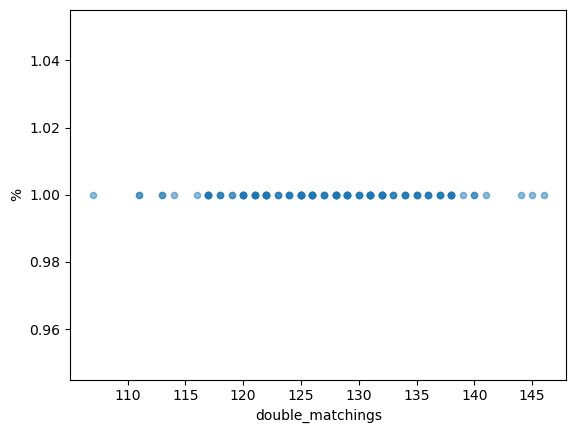

In [16]:
df = pd.read_csv("results.csv")
df.plot.scatter(x = "double_matchings", y = "%", alpha = 0.5)